<a href="https://colab.research.google.com/github/TianYubo/diffusion-nbs/blob/master/Stable_Diffusion_Deep_Dive_cn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 深入了解 Stable Diffusion

Stable Diffusion 是一个强大的文本到图像模型。有许多网站和工具可以让使用它变得非常简单。它还[集成在 Huggingface diffusers 库中](https://huggingface.co/blog/stable_diffusion)，在那里生成图像可以简单到如下代码所示：
```python
from diffusers import StableDiffusionPipeline
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", variant="fp16", torch_dtype=torch.float16, use_auth_token=True).to("cuda")
image = pipe("An astronaught scuba diving").images[0]

```

在本笔记本中，我们将深入这些易于使用的接口背后的代码，看看其内部到底发生了什么。我们首先会将上面的功能用一大段令人望而生畏的代码重现出来，然后逐一检查不同的组件，弄清楚它们各自的作用。当你完成本笔记本的学习后，同样的采样循环应该会让你感觉是可以随意调整和修改的。

## 环境设置与导入

你需要登录 HuggingFace 并接受该模型的许可协议——详见 [模型页面](https://huggingface.co/CompVis/stable-diffusion-v1-4)。当你第一次运行此笔记本时，需要取消注释以下两个代码单元格，以安装所需依赖项并使用访问令牌登录 HuggingFace。

In [1]:
# !pip install -q --upgrade transformers==4.25.1 diffusers ftfy accelerate

In [2]:
!pip install -q --upgrade transformers diffusers ftfy accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.3 MB/s eta 0:00:00


In [3]:
from base64 import b64encode

import numpy
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from huggingface_hub import notebook_login

# For video display:
from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging
import os

torch.manual_seed(1)
if not (Path.home()/'.cache/huggingface'/'token').exists(): notebook_login()

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
if "mps" == torch_device: os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = "1"

## 加载模型

这段代码（以及下一节中的代码）来自 [Huggingface 示例笔记本](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb)。

这将下载并设置我们将使用的相关模型和组件。目前我们先运行这段代码，然后进入下一节，检查是否一切正常，再深入学习。

如果你已经加载了一个流水线（pipeline），你也可以通过 `pipe.unet`、`pipe.vae` 等方式访问这些组件。

在本笔记本中，我们没有使用任何节省内存的技巧——如果你发现自己遇到了 GPU 显存不足的问题，可以参考流水线代码中的一些方法来获得灵感，例如注意力切片（attention slicing）、切换为半精度（fp16）、将 VAE 保留在 CPU 上以及其他修改方式。

In [4]:
# Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device);

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

## 一个扩散循环

如果你只是想通过一些文本生成图像，你可以忽略这个笔记本，转而使用现有的工具之一（例如 [DreamStudio](https://beta.dreamstudio.ai/)），或者使用 HuggingFace 提供的简化版流程，如[此处](https://huggingface.co/blog/stable_diffusion)所述。

在这个笔记本中，我们想要做的是更深入地了解其背后的工作原理。因此，我们将首先确保示例代码能够运行。同样，这部分内容改编自 [HF 笔记本](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb)，它看起来也非常类似于你检查[Stable Diffusion pipeline 的 `__call__()` 方法](https://github.com/huggingface/diffusers/blob/main/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py#L200)时所看到的内容。

In [5]:
# 一些设置
prompt = ["A watercolor painting of an otter"]  # 定义用于生成图像的文本提示
height = 512                        # 稳定扩散模型默认生成的图像高度 (像素)
width = 512                         # 稳定扩散模型默认生成的图像宽度 (像素)
num_inference_steps = 30            # 去噪步数，即模型迭代地从噪声中生成图像的次数
guidance_scale = 7.5                # 无分类器指导的缩放因子。更高的值使图像更接近提示，但可能牺牲多样性
generator = torch.manual_seed(32)   # 设置随机种子生成器，以确保初始潜在噪声的可复现性
batch_size = 1                      # 一次生成的图像数量

In [6]:
# 准备文本输入 (Text Preparation)
# 使用分词器将文本提示转换为模型可以理解的数字 ID
text_input = tokenizer(
    prompt,                          # 输入的文本提示列表
    padding="max_length",            # 将所有序列填充到最大长度
    max_length=tokenizer.model_max_length, # 分词器支持的最大序列长度
    truncation=True,                 # 如果文本超过最大长度，则截断
    return_tensors="pt"              # 返回 PyTorch 张量
)

print(f"Tokenized prompt shape: {text_input.input_ids.shape}")

# 在不计算梯度的情况下，获取文本嵌入 (text embeddings)
# 文本嵌入是文本提示的向量表示，用于指导图像生成
with torch.no_grad(): # 禁用梯度计算，因为我们只是进行推理，不需要训练
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0] # 将输入ID移到指定设备 (如GPU)，并通过文本编码器获取嵌入

print(f"Text Embeddings shape: {text_embeddings.shape}")

max_length = text_input.input_ids.shape[-1] # 获取填充后的文本输入的最大长度，用于无条件输入的处理
print(f"max length: {max_length}")

Tokenized prompt shape: torch.Size([1, 77])
Text Embeddings shape: torch.Size([1, 77, 768])
max length: 77


In [7]:
# 准备无条件文本输入 (Unconditional Text Input)
# 这是为了实现无分类器指导 (classifier-free guidance)
# 无条件输入通常是一个空字符串，表示不依赖任何文本提示进行生成
uncond_input = tokenizer(
    [""] * batch_size,               # 创建一个包含 batch_size 个空字符串的列表
    padding="max_length",            # 同样填充到最大长度
    max_length=max_length,           # 使用与条件输入相同的最大长度
    return_tensors="pt"              # 返回 PyTorch 张量
)
# 获取无条件文本嵌入
with torch.no_grad(): # 禁用梯度计算
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] # 将无条件输入ID移到设备并获取嵌入

print(f"Unconditional Embeddings shape: {uncond_embeddings.shape}")

Unconditional Embeddings shape: torch.Size([1, 77, 768])


In [8]:
# 将无条件嵌入和条件嵌入连接起来
# 这是无分类器指导的标准做法，U-Net 模型会同时接收这两种嵌入
# 使得模型可以同时预测与提示相关的噪声和与提示无关的噪声

text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
print(f"Final Text Embeddings shape: {text_embeddings.shape}")

Final Text Embeddings shape: torch.Size([2, 77, 768])


In [9]:
# 准备调度器 (Scheduler Preparation)
def set_timesteps(scheduler, num_inference_steps):
    scheduler.set_timesteps(num_inference_steps) # 设置调度器在推理过程中要使用的步数
    scheduler.timesteps = scheduler.timesteps.to(torch.float32) # 将时间步的数据类型转换为 float32 (这是一个为了兼容 MPS 的小修复)
set_timesteps(scheduler, num_inference_steps) # 调用函数，配置调度器的时间步

In [10]:
# 准备初始潜在表示 (Latent Preparation)
# 图像生成过程不是直接在像素空间操作，而是在一个压缩的潜在空间 (latent space)
# latents 是一个随机噪声张量，作为生成过程的起点

latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8), # 张量的形状：(批大小, U-Net输入通道数, 高度/8, 宽度/8)
                                                          # VAE 会将图像尺寸缩小8倍，所以潜在空间的高度和宽度是原始尺寸的1/8
  generator=generator, # 使用之前定义的随机种子生成器，确保噪声的可复现性
)
latents = latents.to(torch_device) # 将潜在张量移动到指定设备 (如GPU)

# 根据调度器的初始噪声标准差 (sigma) 来缩放初始潜在噪声
# 这是一个重要的初始化步骤，确保噪声的尺度与调度器的期望相符
latents = latents * scheduler.init_noise_sigma # (旧版本可能是 latents = latents * self.scheduler.sigmas[0])
print(f"Latents shape: {latents.shape}")

Latents shape: torch.Size([1, 4, 64, 64])


<ipython-input-10-71a6d7299a43>:6: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8), # 张量的形状：(批大小, U-Net输入通道数, 高度/8, 宽度/8)


In [11]:
# 核心的去噪循环 (Denoising Loop)
# `autocast` 用于自动混合精度计算，可以在不显著损失精度的情况下加速计算并减少内存使用
# "cuda" 表示如果 CUDA 可用，则在 GPU 上使用混合精度；如果不可用，会回退到 CPU，且不使用 autocast (对于 MPS 也不使用)

with autocast("cuda"):
    # 遍历调度器定义的所有时间步 (从高噪声水平到低噪声水平)
    for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):

        # 扩展潜在表示以进行无分类器指导
        # 我们需要对有条件和无条件的输入都进行噪声预测，所以将 latents 复制一份
        # 这样 U-Net 可以一次性处理两种情况，避免两次前向传播
        latent_model_input = torch.cat([latents] * 2)

        # 获取当前时间步 t 对应的噪声标准差 sigma
        sigma = scheduler.sigmas[i] # 注意：在较新的 diffusers 版本中，直接使用时间步 t 可能更常见

        # 根据调度器缩放模型输入 (预处理)
        # 这一步是为了让模型在不同噪声水平下都能更好地工作
        # (旧版本可能是 latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5) )
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # 使用 U-Net 预测噪声残差 (noise residual)
        with torch.no_grad(): # 在推理阶段，不需要计算梯度
            # U-Net 输入：缩放后的潜在表示、当前时间步 t、以及文本嵌入 (包含无条件和有条件)
            # .sample 获取 U-Net 预测的噪声
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # 执行无分类器指导 (Classifier-Free Guidance)
        # 将 U-Net 的输出 (预测的噪声) 分割为两部分：
        # noise_pred_uncond: 基于无条件输入 (空文本) 预测的噪声
        # noise_pred_text:   基于条件输入 (我们的文本提示) 预测的噪声
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)

        # 计算最终的引导噪声
        # 公式：最终噪声 = 无条件噪声 + guidance_scale * (有条件噪声 - 无条件噪声)
        # 这会使得生成的图像更倾向于文本提示的方向
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # 使用调度器的 step 方法计算上一个时间步的潜在表示 (x_t -> x_t-1)
        # 即根据当前预测的噪声，从当前的潜在表示中去除一部分噪声
        # (旧版本可能是 latents = scheduler.step(noise_pred, i, latents)["prev_sample"] )
        latents = scheduler.step(noise_pred, t, latents).prev_sample

  0%|          | 0/30 [00:00<?, ?it/s]

In [12]:
print(f"Noise pred shape: {noise_pred.shape}")
print(f"Latents shape: {latents.shape}")

Noise pred shape: torch.Size([1, 4, 64, 64])
Latents shape: torch.Size([1, 4, 64, 64])


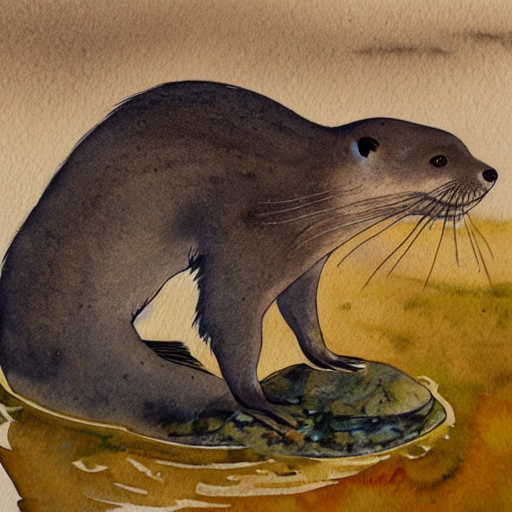

In [13]:
# 缩放并通过 VAE 解码潜在表示，将其转换回图像空间
# 0.18215 是 VAE 的一个缩放因子，用于将潜在表示的范围调整到 VAE 解码器期望的范围
latents = 1 / 0.18215 * latents
with torch.no_grad(): # 不需要梯度计算
    # vae.decode 将潜在表示解码为像素图像
    # .sample 获取解码后的图像样本
    image = vae.decode(latents).sample

# 图像后处理和显示 (Image Post-processing and Display)
# 将图像的像素值从 VAE 输出的范围 (通常是 [-1, 1] 附近) 归一化到 [0, 1]
image = (image / 2 + 0.5).clamp(0, 1)

# 将图像张量从计算设备 (如GPU) 移到 CPU，并分离计算图 (detach)
# 然后调整维度顺序 (permute) 以符合常见的图像格式 (batch, height, width, channels)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()

# 将像素值从 [0, 1] 范围缩放到 [0, 255] 并转换为无符号8位整数 (uint8)，这是图像文件的常见格式
images = (image * 255).round().astype("uint8")

# 将 NumPy 数组转换为 PIL (Pillow) 图像对象列表
pil_images = [Image.fromarray(image) for image in images]

# 显示第一张生成的图像 (因为 batch_size=1，所以只有一张)
pil_images[0] # 在 Jupyter Notebook 或类似环境中，这通常会直接显示图像

它能正常工作，但这代码量可真不少！让我们逐个看看这些组件。

## 自编码器（Autoencoder，AE）

自编码器可以将一张图像“编码”成某种潜在的表示形式，并能将这个表示再解码回图像。我在这里将相关代码封装成了几个函数，这样我们就可以实际看到它的效果：

In [14]:
def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

我们会在这里使用一张来自网络的图片，但你也可以通过上传自己的图片并编辑下一个单元格中的文件名来替换它。

In [15]:
# Download a demo Image
!curl --output macaw.jpg 'https://lafeber.com/pet-birds/wp-content/uploads/2018/06/Scarlet-Macaw-2.jpg'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 58602  100 58602    0     0   316k      0 --:--:-- --:--:-- --:--:--  316k


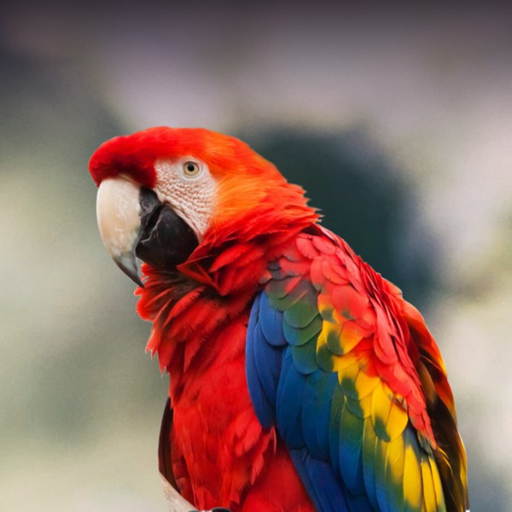

In [16]:
# Load the image with PIL
input_image = Image.open('macaw.jpg').resize((512, 512))
input_image

将此编码到AE的潜在空间，使用上面定义的函数，看起来像这样：

In [17]:
# Encode to the latent space
encoded = pil_to_latent(input_image)
encoded.shape

torch.Size([1, 4, 64, 64])

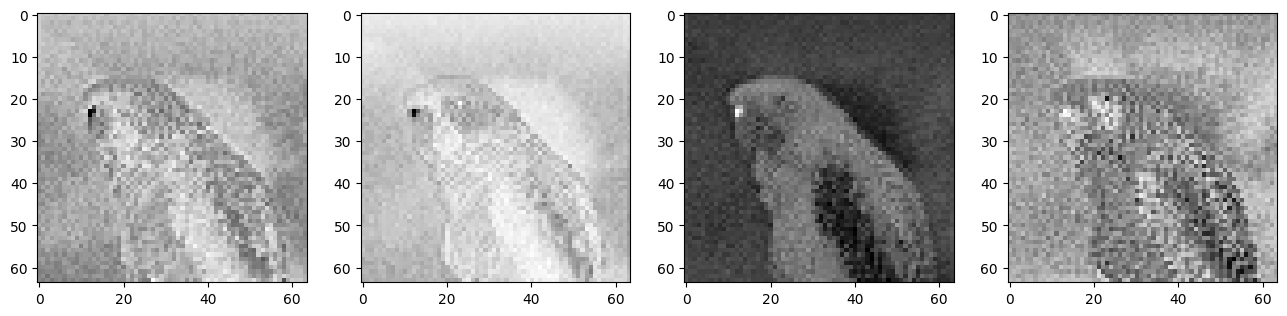

In [18]:
# Let's visualize the four channels of this latent representation:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for c in range(4):
    axs[c].imshow(encoded[0][c].cpu(), cmap='Greys')

这个 4x64x64 的张量捕捉了关于图像的大量信息，希望这些信息足够多，以至于当我们将其输入解码器时，能够还原出与原始输入图像非常接近的结果：

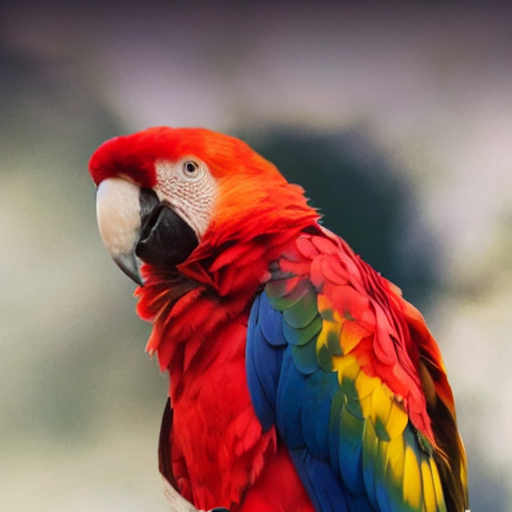

In [19]:
# Decode this latent representation back into an image
decoded = latents_to_pil(encoded)[0]
decoded

你如果仔细观察的话，会发现一些细微的差异！如果你看不到明显的东西，就专注于眼睛部分。这已经相当令人印象深刻了——那个 4x64x64 的潜在空间似乎比一个 64px 的图像包含更多信息。

这个自动编码器（autoencoder）被训练用来将图像压缩成较小的表示形式，然后从这种压缩版本中重新创建回原始图像。

在本特定情况下，压缩因子是 48，我们从一个 3x512x512（ch x ht x wd）的图像开始，然后它被压缩为一个 4x64x64 的潜在向量。输入图像中的每个 3x8x8 像素体积都被压缩为仅 4 个数字（4x1x1）。你可以找到具有更高压缩率的自动编码器（例如像某些流行的 VQGAN 模型一样的 f16），但到了某个点后它们会引入我们不想要的伪影（artifacts）。

我们为什么甚至要使用自动编码器？我们可以在像素空间中进行扩散（diffusion）——在这种情况下，模型接收所有图像数据作为输入，并生成相同形状的输出预测。但这意味着需要处理大量数据，并且高分辨率生成在计算上非常昂贵。有一些解决方案包括在低分辨率下进行扩散（比如 64px），然后再训练一个单独的模型来重复放大（如 D2/Imagen 所做的）。但潜变量扩散（latent diffusion）则是在这个“潜在空间”中执行扩散过程，使用的是来自我们自动编码器的压缩表示而不是原始图像。这些表示信息丰富，并且足够小，可以在消费级硬件上进行有效处理。一旦我们以潜在表示的形式生成了一个新的“图像”，自动编码器就可以把这些最终的潜在输出转化为实际的像素。

# 调度器（Scheduler）

现在我们需要讨论的是如何添加噪声...

在训练过程中，我们会给一张图像添加一些噪声，然后让模型尝试预测这个噪声。如果我们总是添加大量的噪声，模型可能就没有太多可以学习的内容；而如果我们只添加极少量的噪声，那么模型将难以从我们采样时使用的随机起点中产生有意义的结果。因此，在训练过程中，噪声的添加量会根据某种分布进行变化。

在采样过程中，我们需要经过多个步骤来实现“去噪”。具体使用多少步，以及每一步应该去除多少噪声，这些都会影响最终的生成结果。

调度器（scheduler）负责处理上述所有细节。例如：`scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)` 就设置了一个与训练该模型时所使用的调度器一致的调度器。当我们希望在较少的步骤中完成采样时，就可以通过 `scheduler.set_timesteps` 来进行相应的设置：

In [20]:
# Setting the number of sampling steps:
set_timesteps(scheduler, 15)

你可以看到我们新的步骤集如何对应于训练中使用的那些步骤：

In [21]:
# See these in terms of the original 1000 steps used for training:
print(scheduler.timesteps)

tensor([999.0000, 927.6429, 856.2857, 784.9286, 713.5714, 642.2143, 570.8571,
        499.5000, 428.1429, 356.7857, 285.4286, 214.0714, 142.7143,  71.3571,
          0.0000])


以及每个位置存在多少噪声：

In [22]:
# Look at the equivalent noise levels:
print(scheduler.sigmas)

tensor([14.6146,  9.6826,  6.6780,  4.7746,  3.5221,  2.6666,  2.0606,  1.6156,
         1.2768,  1.0097,  0.7913,  0.6056,  0.4397,  0.2780,  0.0292,  0.0000])


在采样过程中，我们将从一个高噪声水平开始（实际上，我们的输入将是纯噪声），并根据此时间表逐渐“去噪”直至生成图像。

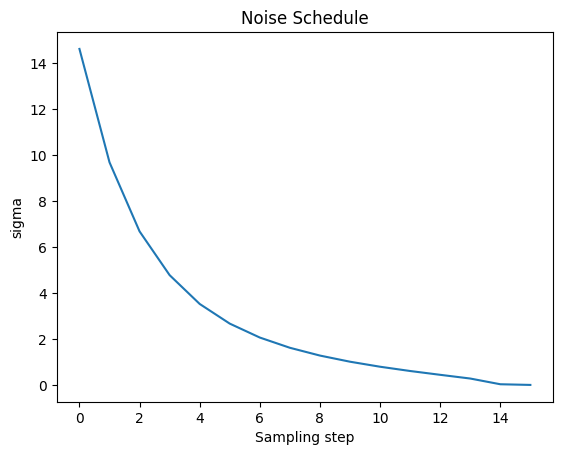

In [26]:
# Plotting this noise schedule:
plt.figure()
plt.plot(scheduler.sigmas)
plt.title('Noise Schedule')
plt.xlabel('Sampling step')
plt.ylabel('sigma')
plt.show()

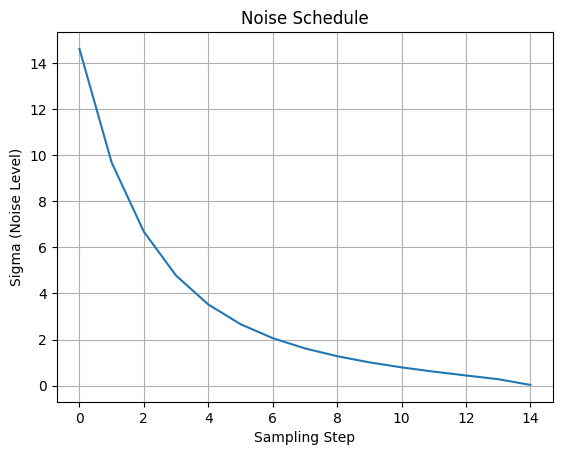

In [27]:
# TODO maybe show timestep as well
plt.figure()
plt.plot(range(len(scheduler.timesteps)), scheduler.sigmas[:len(scheduler.timesteps)])
plt.title('Noise Schedule')
plt.xlabel('Sampling Step')
plt.ylabel('Sigma (Noise Level)')
plt.grid(True)
plt.show()

这个 'sigma' 是指添加到潜在表示中的噪声量。让我们通过给编码后的图像添加一些噪声，然后解码这个加噪版本来可视化一下效果：

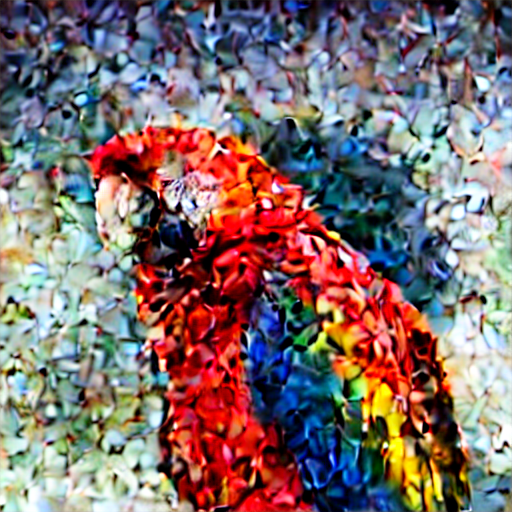

In [28]:
noise = torch.randn_like(encoded) # Random noise
sampling_step = 10 # Equivalent to step 10 out of 15 in the schedule above
# encoded_and_noised = scheduler.add_noise(encoded, noise, timestep) # Diffusers 0.3 and below
encoded_and_noised = scheduler.add_noise(encoded, noise, timesteps=torch.tensor([scheduler.timesteps[sampling_step]]))
latents_to_pil(encoded_and_noised.float())[0] # Display

不同时间步长的情况下会是什么样子？动手实验一下，亲自看看吧！

如果你取消注释下面的单元格，你会发现在这个例子中，`scheduler.add_noise` 函数实际上只是添加了按 sigma 缩放的噪声：`noisy_samples = original_samples + noise * sigmas`

In [29]:
# ??scheduler.add_noise

其他扩散模型可能使用不同的加噪和调度方法进行训练，其中一些方法在不同噪声级别下保持方差相对恒定（称为“方差保留”），并采用不同的缩放和混合技巧，而不是让潜变量随着噪声增加而具有越来越高的方差（称为“方差爆炸”）。

如果我们想从随机噪声开始生成图像，而不是从已加噪的图像开始，我们需要将其乘以训练过程中使用的最大 sigma 值，在本例中约为 14。此外，在这些带噪潜变量输入到模型之前，还会经过一个所谓的预处理步骤进行再次缩放：
`latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)`（现在由 `latent_model_input = scheduler.scale_model_input(latent_model_input, t)` 处理）。

同样需要注意的是，这种缩放/预处理方式在不同论文和实现之间会有所不同，因此如果你使用的是不同类型的扩散模型，请留意这一差异。

## 从输入的加噪版本开始循环（又称 image2image）

让我们看看，当我们使用我们的图像作为起点，添加一些噪声，然后在循环中使用新的提示执行最后几步去噪时会发生什么。

我们将使用与第一个演示类似的循环，但我们会跳过前 `start_step` 步。

为了给图像添加噪声，我们会使用如上所示的代码，利用调度器将图像噪声化到等同于第 10 步（`start_step`）的水平。

In [32]:
# 设置生成图像的参数（与之前相同，只是更新了提示词）
prompt = ["A colorful dancer, nat geo photo"]  # 提示词，描述要生成的图像内容：一个色彩鲜艳的舞者，风格类似国家地理杂志的照片
height = 512                        # 生成图像的高度，默认值为512像素
width = 512                         # 生成图像的宽度，默认值为512像素
num_inference_steps = 50            # 去噪步骤的数量，表示生成过程中要进行的迭代次数
guidance_scale = 8                  # 分类器自由引导的尺度，值越大，生成的图像越贴近提示词描述
generator = torch.manual_seed(32)   # 设置随机种子，用于生成初始潜在噪声，确保结果可重复
batch_size = 1                      # 批次大小，表示一次处理多少张图像，这里为1

In [33]:
# 准备文本输入（与之前相同）
# 将提示词编码为向量形式，以便输入到模型中
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
# 使用文本编码器将输入的文本转换为嵌入向量
with torch.no_grad():  # 禁用梯度计算，节省内存并加速推理
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]  # 获取提示词的嵌入表示
# 获取无条件输入（即空提示词）的嵌入向量，用于分类器自由引导
max_length = text_input.input_ids.shape[-1]  # 获取输入文本的最大长度
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
# 同样，使用文本编码器生成无条件输入的嵌入向量
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
# 将无条件嵌入和条件嵌入（提示词嵌入）拼接在一起，用于后续引导
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

In [34]:
# 准备调度器（设置推理步骤数量）
# 调度器用于控制去噪过程的步长和噪声强度
set_timesteps(scheduler, num_inference_steps)  # 设置总的去噪步数

# 准备潜在变量（为start_step添加适当的噪声）
start_step = 10  # 设置起始步长，表示从第10步开始去噪（可能是因为前几步已经完成或跳过）
start_sigma = scheduler.sigmas[start_step]  # 获取起始步长的噪声强度（sigma值）
noise = torch.randn_like(encoded)  # 生成与编码图像形状相同的随机噪声

# 根据调度器的噪声计划，在特定时间步长上为之前那个鹦鹉图像的 encoded 添加噪声
latents = scheduler.add_noise(encoded, noise, timesteps=torch.tensor([scheduler.timesteps[start_step]]))
latents = latents.to(torch_device).float()  # 将潜在变量移动到指定设备（如GPU）并转换为float类型

  0%|          | 0/50 [00:00<?, ?it/s]

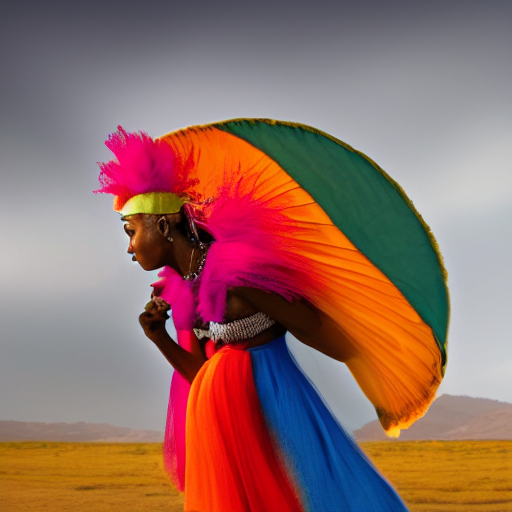

In [35]:
# 去噪循环
# 使用tqdm库显示进度条，遍历调度器中定义的所有时间步长
for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
    if i >= start_step:  # 仅在当前步长大于等于起始步长时执行去噪操作（跳过前面的步长）
        # 扩展潜在变量以进行分类器自由引导，避免两次前向传播
        latent_model_input = torch.cat([latents] * 2)  # 将潜在变量复制一份，分别用于无条件和条件预测
        sigma = scheduler.sigmas[i]  # 获取当前步长的噪声强度
        # 根据当前时间步长调整潜在变量输入的尺度
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # 预测噪声残差
        with torch.no_grad():  # 禁用梯度计算，加速推理
            # 使用UNet模型预测当前潜在变量中的噪声残差，结合文本嵌入作为条件
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # 执行引导操作
        # 将预测的噪声分为无条件部分和条件部分
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        # 使用引导尺度调整噪声预测结果，使其更贴近提示词描述
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # 计算前一个噪声样本，即从当前时间步长x_t到前一时间步长x_t-1的去噪结果
        latents = scheduler.step(noise_pred, t, latents).prev_sample  # 更新潜在变量到前一时间步长的状态

# 将最终的潜在变量转换为图像
latents_to_pil(latents)[0]  # 将去噪后的潜在变量解码为PIL格式的图像并返回第一张（因为batch_size=1）


你可以看到图像中的一些颜色和结构被保留了下来，但现在我们有了一张新的图片！你添加的噪声越多，执行的步骤越多，最终的图像就会离输入图像越远。

这就是流行的 img2img 流程的工作原理。同样地，如果这正是你的目标，有一些工具可以让这个过程变得简单。

但你可以看到，其实这与生成循环是相同的流程，只是跳过了最开始的几步，从一张带有噪声的图像开始，而不是从纯噪声开始。

尝试调整跳过的步骤数量，观察这对图像相对于输入图像的变化程度有何影响。

## 探索文本 -> 嵌入（embedding）流程

我们使用一个文本编码器模型将文本转换为一组“嵌入”（embeddings），这些嵌入作为条件输入到扩散模型中。让我们通过这个过程来跟踪一段文本，看看它是如何工作的。

In [36]:
# Our text prompt
prompt = 'A picture of a puppy'

我们从分词（tokenization）开始：

In [37]:
# Turn the text into a sequnce of tokens:
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
text_input['input_ids'][0] # View the tokens

tensor([49406,   320,  1674,   539,   320,  6829, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407])

In [38]:
# See the individual tokens
for t in text_input['input_ids'][0][:8]: # We'll just look at the first 7 to save you from a wall of '<|endoftext|>'
    print(t, tokenizer.decoder.get(int(t)))

tensor(49406) <|startoftext|>
tensor(320) a</w>
tensor(1674) picture</w>
tensor(539) of</w>
tensor(320) a</w>
tensor(6829) puppy</w>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>


In [39]:
# TODO call out that 6829 is puppy

我们可以直接跳转到最终（输出）嵌入，如下所示：

In [40]:
# Grab the output embeddings
output_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
print('Shape:', output_embeddings.shape)
output_embeddings

Shape: torch.Size([1, 77, 768])


tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
         [ 0.6942,  0.3538,  1.0991,  ..., -1.5716, -1.2643, -0.0121],
         ...,
         [-0.0221, -0.0053, -0.0089,  ..., -0.7303, -1.3830, -0.3011],
         [-0.0062, -0.0246,  0.0065,  ..., -0.7326, -1.3745, -0.2953],
         [-0.0536,  0.0269,  0.0444,  ..., -0.7159, -1.3634, -0.3075]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

我们将 token 输入到 text_encoder 中，然后神奇地得到了一些可以输入给模型的数字。

这些数字是如何生成的呢？token 会被转换为一组输入嵌入（input embeddings），然后通过 transformer 模型以得到最终的输出嵌入。

要获得这些输入嵌入，实际上有两个步骤——通过检查 `text_encoder.text_model.embeddings` 可以看出：

In [41]:
text_encoder.text_model.embeddings

CLIPTextEmbeddings(
  (token_embedding): Embedding(49408, 768)
  (position_embedding): Embedding(77, 768)
)

### Token embeddings

token 会被输入到 `token_embedding` 中以将其转换为一个向量。这里的函数名 `get_input_embeddings` 容易引起误解，因为这些 token embeddings 在实际作为模型输入之前还需要与 position embeddings 结合！无论如何，我们先来看看 token embedding 部分。

我们可以查看嵌入层：

In [42]:
# Access the embedding layer
token_emb_layer = text_encoder.text_model.embeddings.token_embedding
token_emb_layer # Vocab size 49408, emb_dim 768

Embedding(49408, 768)

并且像这样嵌入一个令牌：

In [43]:
# Embed a token - in this case the one for 'puppy'
embedding = token_emb_layer(torch.tensor(6829, device=torch_device))
embedding.shape # 768-dim representation

torch.Size([768])

这个单独的 token 被映射到一个 768 维的向量——即 token 嵌入（token embedding）。

我们也可以对提示（prompt）中的所有 token 执行相同的操作，以得到所有的 token 嵌入：

In [44]:
token_embeddings = token_emb_layer(text_input.input_ids.to(torch_device))
print(token_embeddings.shape) # batch size 1, 77 tokens, 768 values for each
token_embeddings

torch.Size([1, 77, 768])


tensor([[[ 0.0011,  0.0032,  0.0003,  ..., -0.0018,  0.0003,  0.0019],
         [ 0.0013, -0.0011, -0.0126,  ..., -0.0124,  0.0120,  0.0080],
         [ 0.0235, -0.0118,  0.0110,  ...,  0.0049,  0.0078,  0.0160],
         ...,
         [ 0.0012,  0.0077, -0.0011,  ..., -0.0015,  0.0009,  0.0052],
         [ 0.0012,  0.0077, -0.0011,  ..., -0.0015,  0.0009,  0.0052],
         [ 0.0012,  0.0077, -0.0011,  ..., -0.0015,  0.0009,  0.0052]]],
       device='cuda:0', grad_fn=<EmbeddingBackward0>)

### 位置嵌入（Positional Embeddings）

位置嵌入告诉模型一个标记（token）在其序列中的位置。与标记嵌入类似，这也是一组（可选的可学习）参数。但现在我们不再需要处理大约 50,000 个标记，而只需要为每个位置提供一个嵌入参数（总共 77 个位置）：

In [45]:
pos_emb_layer = text_encoder.text_model.embeddings.position_embedding
pos_emb_layer

Embedding(77, 768)

我们可以得到每个位置的位置编码（positional embedding）：

In [46]:
position_ids = text_encoder.text_model.embeddings.position_ids[:, :77]
position_embeddings = pos_emb_layer(position_ids)
print(position_embeddings.shape)
position_embeddings

torch.Size([1, 77, 768])


tensor([[[ 0.0016,  0.0020,  0.0002,  ..., -0.0013,  0.0008,  0.0015],
         [ 0.0042,  0.0029,  0.0002,  ...,  0.0010,  0.0015, -0.0012],
         [ 0.0018,  0.0007, -0.0012,  ..., -0.0029, -0.0009,  0.0026],
         ...,
         [ 0.0216,  0.0055, -0.0101,  ..., -0.0065, -0.0029,  0.0037],
         [ 0.0188,  0.0073, -0.0077,  ..., -0.0025, -0.0009,  0.0057],
         [ 0.0330,  0.0281,  0.0289,  ...,  0.0160,  0.0102, -0.0310]]],
       device='cuda:0', grad_fn=<EmbeddingBackward0>)

### 结合 token 和位置嵌入

现在是时候将两者结合起来。我们该怎么做呢？只需将它们相加！也可以采用其他方法，但对于本模型来说就是这么简单。

以这种方式将它们结合后，就得到了最终的输入嵌入，可以输入到 transformer 模型中：

In [47]:
# And combining them we get the final input embeddings
input_embeddings = token_embeddings + position_embeddings
print(input_embeddings.shape)
input_embeddings

torch.Size([1, 77, 768])


tensor([[[ 2.6770e-03,  5.2133e-03,  4.9323e-04,  ..., -3.1321e-03,
           1.0659e-03,  3.4316e-03],
         [ 5.5371e-03,  1.7510e-03, -1.2381e-02,  ..., -1.1410e-02,
           1.3508e-02,  6.8378e-03],
         [ 2.5356e-02, -1.1019e-02,  9.7663e-03,  ...,  1.9460e-03,
           6.8375e-03,  1.8573e-02],
         ...,
         [ 2.2781e-02,  1.3262e-02, -1.1241e-02,  ..., -8.0054e-03,
          -2.0560e-03,  8.9366e-03],
         [ 2.0026e-02,  1.5015e-02, -8.7638e-03,  ..., -4.0313e-03,
           1.8487e-05,  1.0885e-02],
         [ 3.4206e-02,  3.5826e-02,  2.7768e-02,  ...,  1.4465e-02,
           1.1110e-02, -2.5745e-02]]], device='cuda:0', grad_fn=<AddBackward0>)

我们可以检查这些是否与从 `text_encoder.text_model.embeddings` 得到的结果相同：

In [48]:
# The following combines all the above steps (but doesn't let us fiddle with them!)
text_encoder.text_model.embeddings(text_input.input_ids.to(torch_device))

tensor([[[ 2.6770e-03,  5.2133e-03,  4.9323e-04,  ..., -3.1321e-03,
           1.0659e-03,  3.4316e-03],
         [ 5.5371e-03,  1.7510e-03, -1.2381e-02,  ..., -1.1410e-02,
           1.3508e-02,  6.8378e-03],
         [ 2.5356e-02, -1.1019e-02,  9.7663e-03,  ...,  1.9460e-03,
           6.8375e-03,  1.8573e-02],
         ...,
         [ 2.2781e-02,  1.3262e-02, -1.1241e-02,  ..., -8.0054e-03,
          -2.0560e-03,  8.9366e-03],
         [ 2.0026e-02,  1.5015e-02, -8.7638e-03,  ..., -4.0313e-03,
           1.8487e-05,  1.0885e-02],
         [ 3.4206e-02,  3.5826e-02,  2.7768e-02,  ...,  1.4465e-02,
           1.1110e-02, -2.5745e-02]]], device='cuda:0', grad_fn=<AddBackward0>)

### 将这些输入传递给 Transformer 模型

![transformer 示意图](https://github.com/johnowhitaker/tglcourse/raw/main/images/text_encoder_noborder.png)

我们想要在将输入嵌入（特别是 token 嵌入）送入模型其余部分之前对它们进行一些处理，但首先我们应该确认我们知道如何做到这一点。我阅读了 text_encoders 的 `forward` 方法的代码，并基于此查看了 text_encoder 所包装的 text_model 的 `forward` 方法的代码。如果你想自己检查，可以输入 `??text_encoder.text_model.forward`，你就能看到函数的信息和源代码——这是一个很有用的调试技巧！

无论如何，根据这些信息，我们可以复制我们需要的部分，以获取所谓的“最后隐藏状态”，从而生成我们的最终嵌入：

In [59]:
def build_causal_attention_mask(bsz, seq_len, dtype):
    mask = torch.full((bsz, 1, seq_len, seq_len), float("-inf"), dtype=dtype)
    mask = torch.triu(mask, diagonal=1)  # 上三角矩阵，diagonal=1 表示从对角线以上开始填充 -inf
    return mask

In [60]:
def get_output_embeds(input_embeddings):
    # CLIP's text model uses causal mask, so we prepare it here:
    bsz, seq_len = input_embeddings.shape[:2]
    # causal_attention_mask = text_encoder.text_model._build_causal_attention_mask(bsz, seq_len, dtype=input_embeddings.dtype)
    causal_attention_mask = build_causal_attention_mask(bsz, seq_len, dtype=input_embeddings.dtype)

    # Getting the output embeddings involves calling the model with passing output_hidden_states=True
    # so that it doesn't just return the pooled final predictions:
    encoder_outputs = text_encoder.text_model.encoder(
        inputs_embeds=input_embeddings,
        attention_mask=None, # We aren't using an attention mask so that can be None
        causal_attention_mask=causal_attention_mask.to(torch_device),
        output_attentions=None,
        output_hidden_states=True, # We want the output embs not the final output
        return_dict=None,
    )

    # We're interested in the output hidden state only
    output = encoder_outputs[0]

    # There is a final layer norm we need to pass these through
    output = text_encoder.text_model.final_layer_norm(output)

    # And now they're ready!
    return output

out_embs_test = get_output_embeds(input_embeddings) # Feed through the model with our new function
print(out_embs_test.shape) # Check the output shape
out_embs_test # Inspect the output

torch.Size([1, 77, 768])


tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
         [ 0.6942,  0.3538,  1.0991,  ..., -1.5716, -1.2643, -0.0121],
         ...,
         [-0.6034, -0.5322,  0.0629,  ..., -0.3964,  0.0877, -0.9558],
         [-0.5936, -0.5407,  0.0731,  ..., -0.3876,  0.0906, -0.9436],
         [-0.6393, -0.4703,  0.1103,  ..., -0.3904,  0.1351, -0.9726]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

请注意，这些与我们在开头附近看到的 `output_embeddings` 相匹配——我们已经弄清楚了如何将那个单个步骤（“获取文本嵌入”）拆分成多个子步骤，以便我们进行修改。

现在我们已经有了这个流程，就可以用我们自己选择的新嵌入替换某个标记的输入嵌入——在最终的使用场景中，这将是一个我们学习得到的嵌入。为了演示这个概念，我们将一直使用的提示词中的 'puppy' 的输入嵌入替换为标记 2368 的嵌入，基于此获得一组新的输出嵌入，并使用这些嵌入生成一张图像，看看结果是什么：

In [61]:
prompt = 'A picture of a puppy'

# Tokenize
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
input_ids = text_input.input_ids.to(torch_device)

# Get token embeddings
token_embeddings = token_emb_layer(input_ids)

# The new embedding. In this case just the input embedding of token 2368... (cat)
replacement_token_embedding = text_encoder.get_input_embeddings()(torch.tensor(2368, device=torch_device))

# Insert this into the token embeddings (
token_embeddings[0, torch.where(input_ids[0]==6829)] = replacement_token_embedding.to(torch_device)

# Combine with pos embs
input_embeddings = token_embeddings + position_embeddings

#  Feed through to get final output embs
modified_output_embeddings = get_output_embeds(input_embeddings)

print(modified_output_embeddings.shape)
modified_output_embeddings

torch.Size([1, 77, 768])


tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
         [ 0.6942,  0.3538,  1.0991,  ..., -1.5716, -1.2643, -0.0121],
         ...,
         [-0.6034, -0.5322,  0.0629,  ..., -0.3964,  0.0877, -0.9558],
         [-0.5936, -0.5407,  0.0731,  ..., -0.3876,  0.0906, -0.9436],
         [-0.6393, -0.4703,  0.1103,  ..., -0.3904,  0.1351, -0.9726]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

前几个是相同的，最后一个则不是。从我们替换的 token 的位置开始及其之后的所有内容都会受到影响。

如果一切顺利，当我们使用这些内容生成图像时，应该会看到除小狗之外的其他东西。而且确实如此！

In [62]:
#Generating an image with these modified embeddings

def generate_with_embs(text_embeddings):
    height = 512                        # default height of Stable Diffusion
    width = 512                         # default width of Stable Diffusion
    num_inference_steps = 30            # Number of denoising steps
    guidance_scale = 7.5                # Scale for classifier-free guidance
    generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
    batch_size = 1

    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer(
      [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Prep Scheduler
    set_timesteps(scheduler, num_inference_steps)

    # Prep latents
    latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
    )
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma

    # Loop
    for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    return latents_to_pil(latents)[0]


<ipython-input-62-cf1a6b64d874>:24: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/30 [00:00<?, ?it/s]

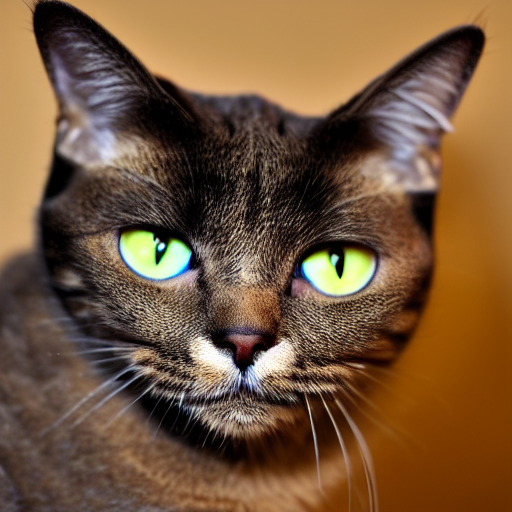

In [63]:
generate_with_embs(modified_output_embeddings)

惊喜！现在你知道 token 2368 是什么意思了 ;)

**我们能用这个做什么？** 我们为什么要费这么大的劲呢？好吧，我们很快会看到一个更吸引人的用例，但简要来说，就是一旦我们可以访问和修改 token 的嵌入表示，我们就可以做一些技巧，比如用其他内容替换它们。在刚才的例子中，我们只是使用了模型词汇表中的另一个 token 嵌入，这相当于只是编辑了提示词。但我们也可以混合不同的 token —— 例如，下面就是一个半是小狗、半是臭鼬的示例：

In [64]:
# In case you're wondering how to get the token for a word, or the embedding for a token:
prompt = 'skunk'
print('tokenizer(prompt):', tokenizer(prompt))
print('token_emb_layer([token_id]) shape:', token_emb_layer(torch.tensor([8797], device=torch_device)).shape)

tokenizer(prompt): {'input_ids': [49406, 42194, 49407], 'attention_mask': [1, 1, 1]}
token_emb_layer([token_id]) shape: torch.Size([1, 768])


<ipython-input-62-cf1a6b64d874>:24: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/30 [00:00<?, ?it/s]

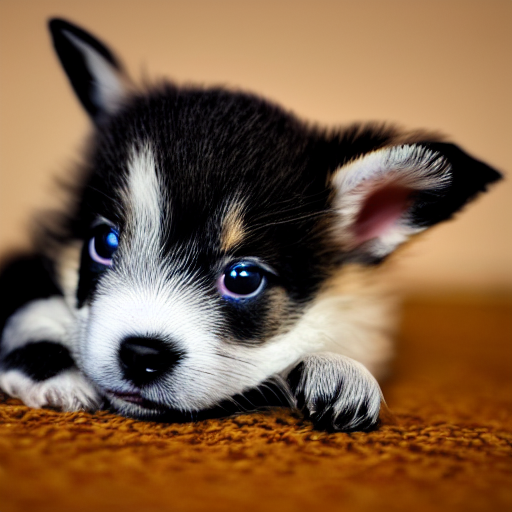

In [65]:
prompt = 'A picture of a puppy'

# Tokenize
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
input_ids = text_input.input_ids.to(torch_device)

# Get token embeddings
token_embeddings = token_emb_layer(input_ids)

# The new embedding. Which is now a mixture of the token embeddings for 'puppy' and 'skunk'
puppy_token_embedding = token_emb_layer(torch.tensor(6829, device=torch_device))
skunk_token_embedding = token_emb_layer(torch.tensor(42194, device=torch_device))
replacement_token_embedding = 0.5*puppy_token_embedding + 0.5*skunk_token_embedding

# Insert this into the token embeddings (
token_embeddings[0, torch.where(input_ids[0]==6829)] = replacement_token_embedding.to(torch_device)

# Combine with pos embs
input_embeddings = token_embeddings + position_embeddings

#  Feed through to get final output embs
modified_output_embeddings = get_output_embeds(input_embeddings)

# Generate an image with these
generate_with_embs(modified_output_embeddings)

### 文本反转（Textual Inversion）

好的，我们可以插入一个修改后的 token embedding，并使用它来生成图像。在上面的例子中，我们使用了表示“cat”的 token embedding，但如果我们可以为某个特定概念“学习”一个新的 token embedding 呢？这就是“文本反转”（Textual Inversion）背后的思想——使用几张示例图像来创建一个新的 token embedding：

![来自博客文章的概述图](https://textual-inversion.github.io/static/images/training/training.JPG)
_图来自 [textual inversion 博客文章](https://textual-inversion.github.io/static/images/training/training.JPG) —— 为了简化说明，图中未显示位置嵌入（positional embeddings）步骤_

我们不会详细介绍这种训练是如何工作的，但我们可以尝试从 [社区创建的 SD 概念库](https://huggingface.co/sd-concepts-library) 加载其中一个新“概念”，并看看它是如何与我们上面的例子结合使用的。我将使用 https://huggingface.co/sd-concepts-library/birb-style ，因为这是我制作的第一个概念 :) 请从该页面下载 learned_embeds.bin 文件，并在运行下一个单元格之前将其上传到当前笔记本所在的位置：

In [ ]:
birb_embed = torch.load('learned_embeds.bin')
birb_embed.keys(), birb_embed['<birb-style>'].shape

我们得到一个字典，其中包含一个键（我使用的特殊占位符，<birb-style>）和相应的 token 嵌入。与前面的例子一样，让我们用这个替换“puppy” token 的嵌入，并看看会发生什么：

In [ ]:
prompt = 'A mouse in the style of puppy'

# Tokenize
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
input_ids = text_input.input_ids.to(torch_device)

# Get token embeddings
token_embeddings = token_emb_layer(input_ids)

# The new embedding - our special birb word
replacement_token_embedding = birb_embed['<birb-style>'].to(torch_device)

# Insert this into the token embeddings
token_embeddings[0, torch.where(input_ids[0]==6829)] = replacement_token_embedding.to(torch_device)

# Combine with pos embs
input_embeddings = token_embeddings + position_embeddings

#  Feed through to get final output embs
modified_output_embeddings = get_output_embeds(input_embeddings)

# And generate an image with this:
generate_with_embs(modified_output_embeddings)

“puppy”的 token 被替换为一个能够捕捉特定绘画风格的 token，但它同样也可以代表一个具体的物体或一类物体。

同样，hf 提供了一个[很棒的推理 notebook ](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_conceptualizer_inference.ipynb)，可以轻松使用不同的概念，并且能够正确处理在提示中使用名称（例如 "A \<cat-toy> in the style of \<birb-style>"），而无需担心所有这些手动操作。这个 notebook 的目的是揭开背后运行机制的一点点神秘面纱，让你了解幕后发生的事情 :)

## 混淆嵌入（Embeddings）

除了仅仅替换单个单词的标记嵌入（token embedding）之外，我们还可以尝试各种其他技巧。例如，如果我们通过对两个不同提示（prompt）的嵌入进行平均来创建一个“嵌合体”（chimera），会发生什么呢？

<ipython-input-49-cf1a6b64d874>:24: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/30 [00:00<?, ?it/s]

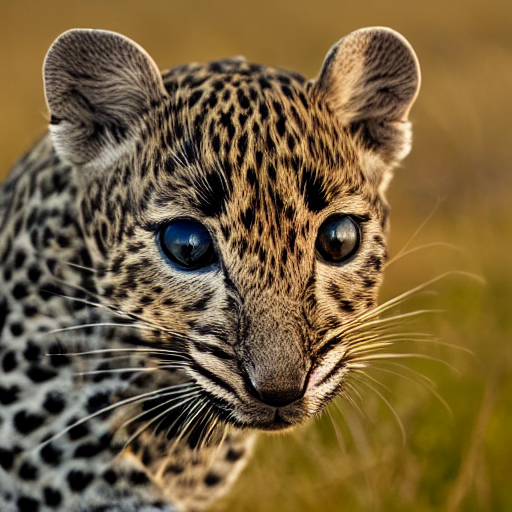

In [ ]:
# Embed two prompts
text_input1 = tokenizer(["A mouse"], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
text_input2 = tokenizer(["A leopard"], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings1 = text_encoder(text_input1.input_ids.to(torch_device))[0]
    text_embeddings2 = text_encoder(text_input2.input_ids.to(torch_device))[0]

# Mix them together
mix_factor = 0.35
mixed_embeddings = (text_embeddings1*mix_factor + \
                   text_embeddings2*(1-mix_factor))

# Generate!
generate_with_embs(mixed_embeddings)

## UNET 与 CFG

现在我们来看看实际的扩散模型。这通常是一个 U-Net（Unet），它接收带噪声的潜在变量（x）并预测噪声。我们使用的是一个条件模型，同时接收时间步（t）和我们的文本嵌入（即 encoder_hidden_states）作为条件输入。将所有这些输入送入模型的过程如下所示：
`noise_pred = unet(latents, t, encoder_hidden_states=text_embeddings)["sample"]`

我们可以尝试运行一下，看看输出是什么样子：

In [ ]:
# Prep Scheduler
set_timesteps(scheduler, num_inference_steps)

# What is our timestep
t = scheduler.timesteps[0]
sigma = scheduler.sigmas[0]

# A noisy latent
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma

# Text embedding
text_input = tokenizer(['A macaw'], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

# Run this through the unet to predict the noise residual
with torch.no_grad():
    noise_pred = unet(latents, t, encoder_hidden_states=text_embeddings)["sample"]

latents.shape, noise_pred.shape # We get preds in the same shape as the input

<ipython-input-57-ce3cf74046df>:10: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


(torch.Size([1, 4, 64, 64]), torch.Size([1, 4, 64, 64]))

给定一组带噪声的潜在表示（noisy latents），模型会预测其中的噪声部分。我们可以从带噪声的潜在表示中减去该预测的噪声，以得到输出图像的样子（`latents_x0 = latents - sigma * noise_pred`）。然后，我们可以将大部分噪声重新加回到这个预测的输出上，以获得下一个扩散步骤的输入（希望稍微不那么嘈杂一点）。为了可视化这一点，我们生成另一张图像，并在每一步都保存预测的输出（x0）和下一步的结果（xt-1）：

In [ ]:
prompt = 'Oil painting of an otter in a top hat'
height = 512
width = 512
num_inference_steps = 50
guidance_scale = 8
generator = torch.manual_seed(32)
batch_size = 1

# Make a folder to store results
!rm -rf steps/
!mkdir -p steps/

# Prep text
text_input = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
set_timesteps(scheduler, num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma

# Loop
for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # Get the predicted x0:
    # latents_x0 = latents - sigma * noise_pred # Calculating ourselves
    scheduler_step = scheduler.step(noise_pred, t, latents)
    latents_x0 = scheduler_step.pred_original_sample # Using the scheduler (Diffusers 0.4 and above)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler_step.prev_sample

    # To PIL Images
    im_t0 = latents_to_pil(latents_x0)[0]
    im_next = latents_to_pil(latents)[0]

    # Combine the two images and save for later viewing
    im = Image.new('RGB', (1024, 512))
    im.paste(im_next, (0, 0))
    im.paste(im_t0, (512, 0))
    im.save(f'steps/{i:04}.jpeg')

<ipython-input-58-967bd506cae4>:30: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
# Make and show the progress video (change width to 1024 for full res)
!ffmpeg -v 1 -y -f image2 -framerate 12 -i steps/%04d.jpeg -c:v libx264 -preset slow -qp 18 -pix_fmt yuv420p out.mp4
mp4 = open('out.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=600 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

右边的版本显示了每一步预测的“最终输出”（x0），这通常用于进度视频等场景。左边的版本是“下一步”。我发现对比这两个版本很有趣——仅观看进度视频时，你可能会认为在早期阶段发生了剧烈的变化，但由于每一步的变化相对较小，实际过程要渐进得多。

### 无分类器指导（Classifier Free Guidance）

默认情况下，模型并不总是按照我们的要求执行。如果我们希望它更好地遵循提示词（prompt），我们会使用一种称为 CFG 的技巧。这个视频中有一个很好的解释（AI coffee break GLIDE）。

在代码中，这相当于我们执行以下操作：

`noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)`

这方法出奇地有效 :) 你可以尝试修改上面代码中的 guidance_scale，看看它是如何影响结果的。在结果变差之前，你能把它调多高？

## 采样（Sampling）

我们仍然没有看到 `latents = scheduler.step(noise_pred, i, latents)["prev_sample"]` 内部的一些复杂性。采样器究竟是如何从当前带噪声的潜在表示（latents）得到一个稍微少一些噪声的版本的？为什么我们不能直接在一个步骤中使用模型？有没有其他方式可以看待这个过程？

模型试图预测图像中的噪声。对于较低的噪声值，我们假设模型能够完成得相当好。但对于较高的噪声水平来说，这是一项困难的任务！因此，模型生成的结果往往看起来像一团模糊混乱的画面 —— 可以查看上面视频的开头来获得一个直观感受。所以，采样器会利用模型的预测结果，朝着模型预测的方向移动一小步（即去除一部分噪声），然后基于这种略微改善后的输入再次进行预测，并希望这样通过迭代逐步提升最终结果。

不同的采样器以不同的方式实现这一点。你可以尝试查看默认 LMS 采样器的代码：

In [ ]:
# ??scheduler.step

**是时候画一些示意图了！**(白板/纸张插图)

# 指导

好的，最后一个技巧！我们如何在这个生成过程中添加一些额外的控制？

在每一步中，我们将像以前一样使用模型来预测 x 的噪声分量。然后我们会用这个预测值生成一张输出图像，并对这张图像应用某种损失函数。

这个函数可以是任意的，但我们先用一个非常简单的例子来演示。如果我们希望图像中有较多的蓝色，我们可以设计一个损失函数，当像素的蓝色分量较低时给出较大的损失值：

In [ ]:
def blue_loss(images):
    # How far are the blue channel values to 0.9:
    error = torch.abs(images[:,2] - 0.9).mean() # [:,2] -> all images in batch, only the blue channel
    return error

在每次更新步骤中，我们找到损失相对于当前带噪声潜在变量的梯度，并在减少该损失的方向上对其进行调整，同时执行正常的更新步骤：

<ipython-input-62-280d35d8e1ff>:29: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/50 [00:00<?, ?it/s]

0 loss: 181.97967529296875
10 loss: 43.4675407409668
20 loss: 15.292802810668945
30 loss: 9.754570960998535
40 loss: 8.830920219421387


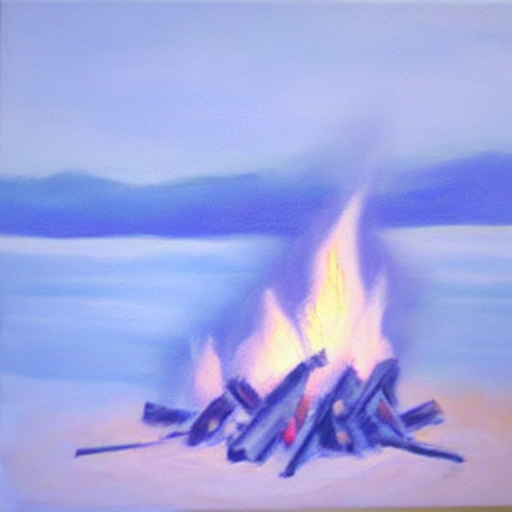

In [ ]:
prompt = 'A campfire (oil on canvas)' #@param
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 50  #@param           # Number of denoising steps
guidance_scale = 8 #@param               # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1
blue_loss_scale = 200 #@param

# Prep text
text_input = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

# And the uncond. input as before:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
set_timesteps(scheduler, num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma

# Loop
for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

    # perform CFG
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    #### ADDITIONAL GUIDANCE ###
    if i%5 == 0:
        # Requires grad on the latents
        latents = latents.detach().requires_grad_()

        # Get the predicted x0:
        latents_x0 = latents - sigma * noise_pred
        # latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

        # Decode to image space
        denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 # range (0, 1)

        # Calculate loss
        loss = blue_loss(denoised_images) * blue_loss_scale

        # Occasionally print it out
        if i%10==0:
            print(i, 'loss:', loss.item())

        # Get gradient
        cond_grad = torch.autograd.grad(loss, latents)[0]

        # Modify the latents based on this gradient
        latents = latents.detach() - cond_grad * sigma**2

    # Now step with scheduler
    latents = scheduler.step(noise_pred, t, latents).prev_sample


latents_to_pil(latents)[0]

调整比例（`blue_loss_scale`）- 在较低的值时，由于提示词的作用，图像大多是红色和橙色。在较高的值时，图像则大多呈现蓝色！如果值过高，我们就会得到一个纯蓝色的图像。

由于这个过程较慢，你会发现我每隔 5 次迭代才应用一次该损失函数——这是 Jeremy 提出的一个建议，我们保留了这一点，因为对于本次演示来说，这样做节省时间且仍然有效。在你自己的测试中，可以尝试使用更低的损失比例，并改为在每次迭代中都应用它 :)

注意：如果我们想要获得更精确的梯度，那么在进行 U-Net 的前向传播之前（即移除 `with torch.no_grad()`）**必须先**将 latents 设置为 requires_grad=True。但这会额外消耗大量内存。你可能会根据所参考的实现不同而看到两种不同的方法。

使用分类器模型进行引导可以生成特定类别的图像；使用类似 CLIP 的模型进行引导可以帮助更好地匹配文本提示；使用风格损失（style loss）进行引导有助于添加某种特定风格；使用某种感知损失（perceptual loss）进行引导则可以迫使图像整体外观朝向目标图像靠拢。以此类推。

# 结论

希望你现在对使用这些模型生成图像时发生的事情有了更清晰的认识，并且了解了如何以创造性的方式修改这个过程。希望你能因此创造出一些有趣的东西 :)

本 Notebook 由 Jonathan Whitaker 编写，改编自 ['Grokking Stable Diffusion'](https://colab.research.google.com/drive/1dlgggNa5Mz8sEAGU0wFCHhGLFooW_pf1?usp=sharing)，这是我早期为了理解这些组件所做的尝试。如果你发现了问题或者有任何疑问，欢迎随时联系我 @johnowhitaker :) 祝你玩得愉快！